# Imports & Data Initialization

### Analysis imports

In [115]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

### Logging setup

In [ ]:
import sys
import os
from datetime import datetime

logfile = os.path.join("logs", "analysis.log")
sys.stdout = open(logfile, "w")
sys.stderr = sys.stdout

print("=== Analysis started ===")
print("Timestamp:", datetime.now())

### Normalization

In [130]:
# -------------------------
# Load parquet files
# -------------------------
ak_arrayA = ak.from_parquet("data/extracted_dataA.parquet")
ak_arrayB = ak.from_parquet("data/extracted_dataB.parquet")
ak_arrayC = ak.from_parquet("data/extracted_dataC.parquet")
ak_arrayD = ak.from_parquet("data/extracted_dataD.parquet")

ak_array1 = ak.from_parquet("data/extracted_mcgg.parquet")
ak_array2 = ak.from_parquet("data/extracted_mcVBF.parquet")
ak_array3 = ak.from_parquet("data/extracted_mcW.parquet")
ak_array4 = ak.from_parquet("data/extracted_mcZ.parquet")

ak_arraybkg = ak.from_parquet("data/extracted_mcbkg.parquet")

# -------------------------
# Convert to pandas
# -------------------------
dfA = pd.DataFrame({k: ak_arrayA[k].to_list() for k in ak_arrayA.fields})
dfB = pd.DataFrame({k: ak_arrayB[k].to_list() for k in ak_arrayB.fields})
dfC = pd.DataFrame({k: ak_arrayC[k].to_list() for k in ak_arrayC.fields})
dfD = pd.DataFrame({k: ak_arrayD[k].to_list() for k in ak_arrayD.fields})

df = pd.concat([dfA, dfB, dfC, dfD], ignore_index=True)

# -------------------------
# MC normalization parameters
# -------------------------
LUMINOSITY = 10.0  # fb^-1

# 13 TeV Higgs production cross sections (pb)
XS = {
    "ggF": 48.61,
    "VBF": 3.766,
    "WH": 1.358,
    "ZH": 0.88,
    "bkg": 16.7  # ZZ production (pb)
}

# Branching ratios
BR_H_4L = 1.24e-4    # H → ZZ* → 4ℓ (4e, 4mu, 2e2mu)
BR_ZZ_4L = 4.52e-3   # ZZ → 4l

# -------------------------
# Signal MC
# -------------------------
df1 = pd.DataFrame({k: ak_array1[k].to_list() for k in ak_array1.fields})
df2 = pd.DataFrame({k: ak_array2[k].to_list() for k in ak_array2.fields})
df3 = pd.DataFrame({k: ak_array3[k].to_list() for k in ak_array3.fields})
df4 = pd.DataFrame({k: ak_array4[k].to_list() for k in ak_array4.fields})

# Assign weights (sig × BR × L / N_gen)
df1["weight"] = XS["ggF"] * BR_H_4L * LUMINOSITY * 1000 / len(df1) / 2
df2["weight"] = XS["VBF"] * BR_H_4L * LUMINOSITY * 1000 / len(df2) / 2
df3["weight"] = XS["WH"] * BR_H_4L * LUMINOSITY * 1000 / len(df3) / 2
df4["weight"] = XS["ZH"] * BR_H_4L * LUMINOSITY * 1000 / len(df4) / 2

df_sig = pd.concat([df1, df2, df3, df4], ignore_index=True)

# -------------------------
# Background MC
# -------------------------
df_bkg = pd.DataFrame({k: ak_arraybkg[k].to_list() for k in ak_arraybkg.fields})
df_bkg["weight"] = XS["bkg"] * BR_ZZ_4L * LUMINOSITY * 1000 / len(df_bkg) / 2

# -------------------------
# Sanity check
# -------------------------
print("Shapes:", np.shape(df), np.shape(df_sig), np.shape(df_bkg))
print("Total expected signal (10 fb^-1):", df_sig["weight"].sum())
print("Total expected background (10 fb^-1):", df_bkg["weight"].sum())

# Print column names for signal MC datasets
print("Signal MC - ggF (df1) columns:", df1.columns)
print("Signal MC - VBF (df2) columns:", df2.columns)
print("Signal MC - WH (df3) columns:", df3.columns)
print("Signal MC - ZH (df4) columns:", df4.columns)

# Print column names for background MC dataset
print("Background MC (df_bkg) columns:", df_bkg.columns)




# Event selection

### 4-Lepton Selection

In [131]:
# Require exactly four leptons forming 4e, 4mu, or 2e2mu final states
def lep_channel(lep_type):
    lep_type = np.array(lep_type)
    n_e  = np.sum(lep_type == 11)
    n_mu = np.sum(lep_type == 13)
    return (n_e == 4) or (n_mu == 4) or (n_e == 2 and n_mu == 2)

mask_data = df['lep_type'].apply(lep_channel)
mask_sig  = df_sig['lep_type'].apply(lep_channel)
mask_bkg  = df_bkg['lep_type'].apply(lep_channel)

# 4-lepton data
data_4l = df[mask_data]
sig_4l  = df_sig[mask_sig]
bkg_4l  = df_bkg[mask_bkg]

print("4l events, data:", data_4l.shape)
print("\n4l events, mc signal:", sig_4l.shape)
print("\n4l events, mc background:", bkg_4l.shape)

### Cutting functions

In [132]:
# Individual cut functions (for cutflow bookkeeping)

### Forward tracks cut
def cut_eta(event):
    eta = np.abs(np.array(event['lep_eta']))
    return np.all(eta < 2.45)

### Transverse momentum cut (electron, muon)
def cut_pt_flavor(event):
    pt = np.array(event['lep_pt']) / 1000
    t  = np.array(event['lep_type'])
    pass_e  = (t != 11) | (pt > 7)
    pass_mu = (t != 13) | (pt > 6)
    return np.all(pass_e & pass_mu)

### Tight ID cut
def cut_tight_id(event):
    return np.all(event['lep_isTightID'])

### Isolation cut
def cut_isolation(event):
    pt = np.array(event['lep_pt']) / 1000
    ptcone = np.array(event['lep_ptcone30']) / 1000
    return np.all(ptcone / pt < 0.15)

### Leading/subleading/third momentum cut 
def cut_leading_pt(event):
    pt = np.array(event['lep_pt']) / 1000
    pt_sorted = np.sort(pt)[::-1]
    return (pt_sorted[0] > 25) and (pt_sorted[1] > 20) and (pt_sorted[2] > 15)

# Z1 / Z2 reconstruction and mass window selection cut
def z_mass_cut(event):
    pt = np.array(event['lep_pt']) / 1000
    eta = np.abs(np.array(event['lep_eta']))
    phi = np.array(event['lep_phi'])
    t = np.array(event['lep_type'])
    E = np.array(event['lep_E']) / 1000
    charge = np.array(event['lep_charge'])
    
    def inv_mass(E, pt, eta, phi):
        px = pt * np.cos(phi)
        py = pt * np.sin(phi)
        pz = pt * np.sinh(eta)
        E_tot  = np.sum(E)
        px_tot = np.sum(px)
        py_tot = np.sum(py)
        pz_tot = np.sum(pz)
        m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
        return np.sqrt(np.maximum(m2, 0))
        
    # Find all same-flavor opposite-sign lepton pairs
    sfos_pairs = []
    for i in range(4):
        for j in range(i+1, 4):
            if (t[i] == t[j]) and (charge[i] * charge[j] == -1):
                sfos_pairs.append((i, j))
    
    if len(sfos_pairs) < 2:
        return False

    # Leading Z = pair closest to mZ
    mZ = 90
    masses = [inv_mass(E[[i,j]], pt[[i,j]], eta[[i,j]], phi[[i,j]]) for i,j in sfos_pairs]
    idx = np.argmin(np.abs(np.array(masses) - mZ))
    i, j = sfos_pairs[idx]
    m12 = masses[idx]

    # Subleading Z from remaining leptons
    rem = list({0,1,2,3} - {i, j})
    m34 = inv_mass(E[rem], pt[rem], eta[rem], phi[rem])

    # Z mass windows
    if not (50 < m12 < 106):
        return False
    if not (12 < m34 < 115):
        return False
    
    return True


### Cutflow table

In [133]:
# Sequential application of cuts (for cutflow)
cuts = [
    ("4 leptons", None),
    ("|η| < 2.45", cut_eta),
    ("pT (flavor)", cut_pt_flavor),
    ("Tight ID", cut_tight_id),
    ("Isolation", cut_isolation),
    ("Leading pT", cut_leading_pt),
    ("Z mass window", z_mass_cut)
]

def apply_cut(df, cut_func):
    if cut_func is None:
        return df
    return df[df.apply(cut_func, axis=1)]

# Containers for cutflow
cutflow = []

data_tmp, sig_tmp, bkg_tmp = data_4l, sig_4l, bkg_4l

for name, func in cuts:
    data_tmp = apply_cut(data_tmp, func)
    sig_tmp  = apply_cut(sig_tmp, func)
    bkg_tmp  = apply_cut(bkg_tmp, func)

    cutflow.append({
        "Cut": name,
        "Data": len(data_tmp),
        "Signal (MC, 10 fb⁻¹)": sig_tmp['weight'].sum(),
        "Background (MC, 10 fb⁻¹)": bkg_tmp['weight'].sum()
    })

# Final selected datasets (after all cuts)
data_sel = data_tmp
sig_sel  = sig_tmp
bkg_sel  = bkg_tmp

cutflow_df = pd.DataFrame(cutflow)
cutflow_df

,Cut,Data,"Signal (MC, 10 fb⁻¹)","Background (MC, 10 fb⁻¹)"
0,4 leptons,606,33.234563,363.822696
1,|η| < 2.45,579,32.554394,350.053800
2,pT (flavor),579,32.554394,350.053800
3,Tight ID,310,22.311510,250.691821
4,Isolation,248,19.621308,229.491357
5,Leading pT,189,15.341793,202.242276
6,Z mass window,159,12.936411,171.799677


# Results

### Four-Lepton Invariant Mass

In [134]:
# Compute four-lepton invariant mass
def compute_m4l(event):
    pt  = np.array(event['lep_pt']) * 1e-3  # GeV
    eta = np.array(event['lep_eta'])
    phi = np.array(event['lep_phi'])
    E   = np.array(event['lep_E']) * 1e-3  # GeV

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)

    E_tot  = np.sum(E)
    px_tot = np.sum(px)
    py_tot = np.sum(py)
    pz_tot = np.sum(pz)

    m2 = E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2)
    return np.sqrt(np.maximum(m2, 0.0))

# Make copies to avoid SettingWithCopyWarning
data_sel = data_sel.copy()
sig_sel  = sig_sel.copy()
bkg_sel  = bkg_sel.copy()

data_sel['m4l'] = data_sel.apply(compute_m4l, axis=1)
sig_sel['m4l']  = sig_sel.apply(compute_m4l, axis=1)
bkg_sel['m4l']  = bkg_sel.apply(compute_m4l, axis=1)

### 4l m plot

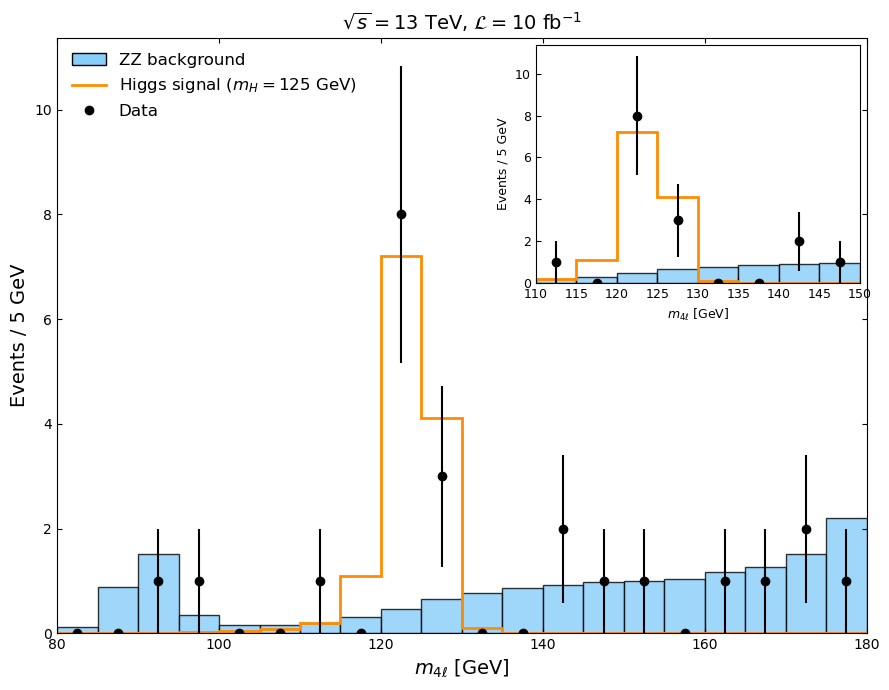

In [136]:
# --------------------------------
# Binning: 80–180 GeV, 5 GeV bins
# --------------------------------
bins = np.arange(80, 185, 5)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Data histogram (for errors)
data_counts, _ = np.histogram(data_sel['m4l'], bins=bins)

# --------------------------------
# Main figure
# --------------------------------
fig, ax = plt.subplots(figsize=(9, 7))

# Background: filled blue
ax.hist(
    bkg_sel['m4l'],
    bins=bins,
    weights=bkg_sel['weight'],
    color='lightskyblue',
    edgecolor='black',
    alpha=0.8
)

# Signal: orange line
ax.hist(
    sig_sel['m4l'],
    bins=bins,
    weights=sig_sel['weight'],
    histtype='step',
    linewidth=2.0,
    color='darkorange'
)

# Data: black points with error bars
ax.errorbar(
    bin_centers,
    data_counts,
    yerr=np.sqrt(data_counts),
    fmt='o',
    color='black'
)

# Axes labels and title
ax.set_xlabel(r'$m_{4\ell}$ [GeV]', fontsize=14)
ax.set_ylabel('Events / 5 GeV', fontsize=14)
ax.set_xlim(80, 180)

ax.set_title(
    r'$\sqrt{s}=13$ TeV, $\mathcal{L}=10~\mathrm{fb}^{-1}$',
    fontsize=14
)

ax.tick_params(direction='in', top=True, right=True)

# --------------------------------
# Legend (explicit handles)
# --------------------------------
legend_handles = [
    Patch(
        facecolor='lightskyblue',
        edgecolor='black',
        label='ZZ background'
    ),
    Line2D(
        [0], [0],
        color='darkorange',
        lw=2.0,
        label=r'Higgs signal ($m_H=125$ GeV)'
    ),
    Line2D(
        [0], [0],
        marker='o',
        color='black',
        linestyle='None',
        label='Data'
    )
]

ax.legend(
    handles=legend_handles,
    loc='upper left',
    frameon=False,
    fontsize=12
)

# --------------------------------
# Inset: Higgs window zoom
# --------------------------------
axins = inset_axes(ax, width="40%", height="40%", loc='upper right')

# Zoom range
zoom_mask = (bins >= 110) & (bins <= 150)
bins_zoom = bins[zoom_mask]

bin_centers_zoom = 0.5 * (bins_zoom[1:] + bins_zoom[:-1])
data_counts_zoom, _ = np.histogram(data_sel['m4l'], bins=bins_zoom)

# Background (zoom)
axins.hist(
    bkg_sel['m4l'],
    bins=bins_zoom,
    weights=bkg_sel['weight'],
    color='lightskyblue',
    edgecolor='black',
    alpha=0.8
)

# Signal (zoom)
axins.hist(
    sig_sel['m4l'],
    bins=bins_zoom,
    weights=sig_sel['weight'],
    histtype='step',
    linewidth=2.0,
    color='darkorange'
)

# Data (zoom)
axins.errorbar(
    bin_centers_zoom,
    data_counts_zoom,
    yerr=np.sqrt(data_counts_zoom),
    fmt='o',
    color='black'
)

axins.set_xlim(110, 150)
axins.set_ylim(bottom=0)
axins.set_xlabel(r'$m_{4\ell}$ [GeV]', fontsize=9)
axins.set_ylabel('Events / 5 GeV', fontsize=9)
axins.tick_params(labelsize=9, direction='in')

# --------------------------------
# Finalize
# --------------------------------
plt.tight_layout()
plt.savefig("logs/m4l_with_inset.png")
plt.show()


### Profile Likelihood Function

In [137]:
def asymptotic_profile_likelihood(s, b, k):
    s = np.asarray(s, dtype=float)
    b = np.asarray(b, dtype=float)
    k = np.asarray(k, dtype=float)

    mask = (s > 0) & (b > 0)
    s = s[mask]
    b = b[mask]
    k = k[mask]

    q0 = 2 * np.sum(
        k * np.log((s + b) / b) - s
    )

    return np.sqrt(np.maximum(q0, 0.0))

### Expected and observed sensitivity

In [138]:
# --- Binned likelihood inputs with sideband-normalized background ---

bins = np.linspace(80, 160, 16)

# Signal (already properly normalized)
s_bins, _ = np.histogram(
    sig_sel['m4l'],
    bins=bins,
    weights=sig_sel['weight']
)

# Background (SIDE-BAND NORMALIZED)
b_bins, _ = np.histogram(
    bkg_sel['m4l'],
    bins=bins,
    weights=bkg_sel['weight']
)

# Observed data
k_data, _ = np.histogram(
    data_sel['m4l'],
    bins=bins
)

# -----------------------------
# Expected significance (Asimov)
# -----------------------------
k_asimov = s_bins + b_bins

Z_expected = asymptotic_profile_likelihood(
    s_bins,
    b_bins,
    k_asimov
)

# -----------------------------
# Observed significance
# -----------------------------
Z_observed = asymptotic_profile_likelihood(
    s_bins,
    b_bins,
    k_data
)

# -----------------------------
# Higgs window yields (115–130 GeV)
# -----------------------------
higgs_window = (sig_sel['m4l'] > 115) & (sig_sel['m4l'] < 130)

N_sig_hw = sig_sel.loc[higgs_window, 'weight'].sum()
N_bkg_hw = bkg_sel.loc[
    (bkg_sel['m4l'] > 115) & (bkg_sel['m4l'] < 130),
    'weight'
].sum()

# -----------------------------
# Reporting
# -----------------------------
print(f"N_sig (115–130 GeV) = {N_sig_hw:.3f}")
print(f"N_bkg (115–130 GeV, sideband-normalized) = {N_bkg_hw:.3f}")
print("Expected significance (Asimov, sideband-normalized):", Z_expected, "σ")
print("Observed significance (sideband-normalized):", Z_observed, "σ")


### Saving logs

In [139]:
print("=== Analysis finished ===")
sys.stdout.flush()